In [13]:
%matplotlib inline

from ROOT import TFile,vector
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import os

from PlottingScripts import CV, Spline, Tune1, distVar, distplot_wratio, distplot_wratio_dvar, StackedHisto, SimpleHisto, mcplot,dist2d_statsonly, Cov,DrawMatrix, datadataplot_wratio,  datadataplot_wratio_dvar
from DetSysScripts import FullCov

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

In [14]:
datafolder = '../../data'
dumpfolder = '../PlotDumps'

RSE  = ['run','subrun','event']

In [15]:
#wc tagger
#NUMU_RUN1_POT = 4.71579e+20 #in full sample
NUMU_RUN1_POT = 4.71579e+20-1.76704330551e+20  # not in training sample

NUMU_RUN2_POT = 4.08963968669e+20

#NUMU_RUN3_POT = 8.98773223801e+20 # in full sample
NUMU_RUN3_POT = 8.98773223801e+20-3.88480441949e+20# not in training

RUN1_FILTER_POT = 1.558e+20 + 1.129e+17 + 1.869e+19   # C1
RUN2_FILTER_POT = (1.63e+20 + 2.964e+19 + 1.239e+19) + (5.923e+19) # D2 + E1
RUN3_FILTER_POT = (1.701e+20 + 2.97e+19 + 1.524e+17) + (4.3e+19)    # G1 + F1
print(RUN1_FILTER_POT+RUN2_FILTER_POT+RUN3_FILTER_POT)

POT_SCALE_FACTOR = RUN2_FILTER_POT
print(POT_SCALE_FACTOR)

NUMU_RUN1_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN1_POT)
NUMU_RUN2_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN2_POT)
NUMU_RUN3_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN3_POT)

RUN3_FT_SCALE = POT_SCALE_FACTOR / float(RUN3_FILTER_POT)
RUN2_FT_SCALE = POT_SCALE_FACTOR/float(RUN2_FILTER_POT)
RUN1_FT_SCALE = POT_SCALE_FACTOR/float(RUN1_FILTER_POT)

6.818153e+20
2.6426e+20


In [16]:
#tag = 'Sept16_bdtseries4'
tag = 'RunCompatibility'

df_numu_run1_presel = pd.read_parquet('%s/pickles/numu_run1_%s.parquet'%(datafolder,tag)).query('InTraining==0')
df_numu_run2_presel= pd.read_parquet('%s/pickles/numu_run2_%s.parquet'%(datafolder,tag))
df_numu_run3_presel= pd.read_parquet('%s/pickles/numu_run3_%s.parquet'%(datafolder,tag)).query('InTraining==0')


df_numu_run1_presel = df_numu_run1_presel.sort_values('bkgBDT_univ',ascending=True).drop_duplicates(RSE).sort_index()
df_numu_run2_presel = df_numu_run2_presel.sort_values('bkgBDT_univ',ascending=True).drop_duplicates('CVIndex').sort_index()
df_numu_run3_presel = df_numu_run3_presel.sort_values('bkgBDT_univ',ascending=True).drop_duplicates(RSE).sort_index()


# remove duplicates

tag = 'Aug10_fullyloaded'

df_data_run1_filter_presel = pd.read_parquet('%s/pickles/data_run1_filter_%s.parquet'%(datafolder,tag))
df_data_run2_filter_presel = pd.read_parquet('%s/pickles/data_run2_filter_%s.parquet'%(datafolder,tag))
df_data_run3_filter_presel = pd.read_parquet('%s/pickles/data_run3_filter_%s.parquet'%(datafolder,tag))

In [17]:
run1FilterTest = SimpleHisto(df_data_run1_filter_presel,RUN1_FT_SCALE,0,'','Run 1 Filtered')
run2FilterTest = SimpleHisto(df_data_run2_filter_presel,RUN2_FT_SCALE,0,'','Run 2 Filtered')
run3FilterTest = SimpleHisto(df_data_run3_filter_presel,RUN3_FT_SCALE,0,'','Run 3 Filtered')

run1NumuHist = SimpleHisto(df_numu_run1_presel,NUMU_RUN1_SCALE,1,'','Run 1 BNB Overlay')
run2NumuHist = SimpleHisto(df_numu_run2_presel,NUMU_RUN2_SCALE,1,'','Run 2 BNB Overlay')
run3NumuHist = SimpleHisto(df_numu_run3_presel,NUMU_RUN3_SCALE,1,'','Run 3 BNB Overlay')

In [18]:
# Make big list of variables with their accompanying ranges so we can just dump a buttload of plots
#varlistSel = {}
covfolder = 'CovMatrices_Aug10'
covtag = 'frac_covar_sel'

varListSel = {}

varListSel['Xreco'] = distVar('Xreco',(15,241.25),'Reco Vertex X',datafolder+'/'+covfolder+'/'+covtag+'__x_reco.txt')
varListSel['Yreco'] = distVar('Yreco',(-101.5,101.5),'Reco Vertex Y',datafolder+'/'+covfolder+'/'+covtag+'__y_reco.txt')
varListSel['Zreco'] = distVar('Zreco',(15,1021.8),'Reco Vertex Z',datafolder+'/'+covfolder+'/'+covtag+'__z_reco.txt')
varListSel['OpenAng'] = distVar('OpenAng',(.6,2.8),'Opening Angle (rads)',datafolder+'/'+covfolder+'/'+covtag+'__openang_reco.txt')
varListSel['Thetas'] = distVar('Thetas',(0,np.pi),r'Sum of Thetas ($\theta_{p} + \theta_{\mu}$) (rads)',datafolder+'/'+covfolder+'/'+covtag+'__sum_thetas_reco.txt')
varListSel['Phis'] = distVar('Phis',(1.5,4),r'Difference of Phis ($|\phi_{p} - \phi_{\mu}|$)  (rads)',datafolder+'/'+covfolder+'/'+covtag+'__sum_phis_reco.txt')
varListSel['ChargeNearTrunk'] = distVar('ChargeNearTrunk',(0,600),'ADC Charge within 5cm of Reco Vertex',datafolder+'/'+covfolder+'/'+covtag+'__charge_near_trunk_reco.txt')
varListSel['Enu_1m1p'] = distVar('Enu_1m1p',(200,1200),'Reconstructed Neutrino Energy (MeV)',datafolder+'/'+covfolder+'/'+covtag+'__nu_energy_reco.txt')
varListSel['PhiT_1m1p'] = distVar('PhiT_1m1p',(0,1),r'$\phi_T$',datafolder+'/'+covfolder+'/'+covtag+'__phiT_reco.txt')
varListSel['AlphaT_1m1p'] = distVar('AlphaT_1m1p',(0,np.pi),r'$\alpha_T$',datafolder+'/'+covfolder+'/'+covtag+'__alphaT_reco.txt')
varListSel['PT_1m1p'] = distVar('PT_1m1p',(0,320),r'$p_T$',datafolder+'/'+covfolder+'/'+covtag+'__pT_reco.txt')
varListSel['PTRat_1m1p'] = distVar('PTRat_1m1p',(0,.4),r'$p_T/|p|$',datafolder+'/'+covfolder+'/'+covtag+'__pT_ratio_reco.txt')
varListSel['BjXB_1m1p'] = distVar('BjXB_1m1p',(.2,1.8),'Bjorken X*',datafolder+'/'+covfolder+'/'+covtag+'__BjxB_reco.txt')
varListSel['BjYB_1m1p'] = distVar('BjYB_1m1p',(0.05,.75),'Bjorken Y*',datafolder+'/'+covfolder+'/'+covtag+'__BjyB_reco.txt')
varListSel['Q2_1m1p'] = distVar('Q2_1m1p',(0,6e5),r'$Q^2$',datafolder+'/'+covfolder+'/'+covtag+'__Q2_reco.txt')
varListSel['SphB_1m1p'] = distVar('SphB_1m1p',(0,1000),'QE Consistency*',datafolder+'/'+covfolder+'/'+covtag+'__sphB_reco.txt')
varListSel['Q0_1m1p'] = distVar('Q0_1m1p',(70,600),r'$Q_0$',datafolder+'/'+covfolder+'/'+covtag+'__Q0_reco.txt')
varListSel['Q3_1m1p'] = distVar('Q3_1m1p',(200,1000),r'$Q_3$',datafolder+'/'+covfolder+'/'+covtag+'__Q3_reco.txt')
varListSel['Lepton_PhiReco'] = distVar('Lepton_PhiReco',(-np.pi,np.pi),r'Muon $\phi$',datafolder+'/'+covfolder+'/'+covtag+'__lepton_phi_reco.txt')
varListSel['Lepton_ThetaReco'] = distVar('Lepton_ThetaReco',(.2,2.8),r'Muon $\theta$',datafolder+'/'+covfolder+'/'+covtag+'__lepton_theta_reco.txt')
varListSel['Lepton_TrackLength'] = distVar('Lepton_TrackLength',(20,200),'Muon Track Length (cm)',datafolder+'/'+covfolder+'/'+covtag+'__lepton_length_reco.txt')
varListSel['Muon_Edep'] = distVar('Muon_Edep',(50,600),'Reco Muon Energy (from range) (MeV)',datafolder+'/'+covfolder+'/'+covtag+'__lepton_KE_reco.txt')
varListSel['Proton_PhiReco'] = distVar('Proton_PhiReco',(-np.pi,np.pi),r'Proton $\phi$',datafolder+'/'+covfolder+'/'+covtag+'__proton_phi_reco.txt')
varListSel['Proton_ThetaReco'] = distVar('Proton_ThetaReco',(0,2),r'Proton $\theta$',datafolder+'/'+covfolder+'/'+covtag+'__proton_theta_reco.txt')
varListSel['Proton_TrackLength'] = distVar('Proton_TrackLength',(5,100),'Proton Track Length',datafolder+'/'+covfolder+'/'+covtag+'__proton_length_reco.txt')
varListSel['Proton_Edep'] = distVar('Proton_Edep',(50,500),'Reco Proton Energy (from range) (MeV)',datafolder+'/'+covfolder+'/'+covtag+'__proton_KE_reco.txt')
varListSel['Proton_CosTheta'] = distVar('Proton_CosTheta',(0,1),'Proton Cos Theta',datafolder+'/'+covfolder+'/'+covtag+'__proton_cos_theta_reco.txt')
varListSel['Lepton_CosTheta'] = distVar('Lepton_CosTheta',(-1,1),'Muon Cos Theta',datafolder+'/'+covfolder+'/'+covtag+'__lepton_cos_theta_reco.txt')
varListSel['MPID_eminus'] = distVar('MPID_eminus',(0,1),'Eminus MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_eminus_score.txt')
varListSel['MPID_muon'] = distVar('MPID_muon',(0,1),'Muon MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_muon_score.txt')
varListSel['MPID_proton'] = distVar('MPID_proton',(0,1),'Proton MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_proton_score.txt')
varListSel['MPID_gamma'] = distVar('MPID_gamma',(0,1),'Gamma MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_gamma_score.txt')
varListSel['MPID_pion'] = distVar('MPID_pion',(0,1),'Pion MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_pion_score.txt')

In [19]:
def poisson_errors(k, CL = 0.6827):
   # 1 Sig = 0.6827
   # 2 Sig = 0.9545
   # 3 Sig = 0.9973
   a = 1.0 - CL
   low, high = (stats.chi2.ppf(a/2, 2*k) / 2, stats.chi2.ppf(1-a/2, 2*k + 2) / 2)
   if k == 0:
       low = 0.0
   return k - low, high - k


def datadataplot_wratio_dvar(dvar,nbins,datahist1,datahist2,datahist3,legpos=0,ymax=-1,normshift=1,fs=(16,11)):
    return datadataplot_wratio(dvar.myname,nbins,dvar.myrange,datahist1,datahist2,datahist3,dvar.mylabel,legpos,ymax,normshift,fs)

def datadataplot_wratio(myvar,nbins,myrange,hist1,hist2,hist3,stxcoord,legpos=0,ymax=-1,normshift=1,fs=(16,11)):

    ndof13 = 0
    ndof23 = 0
    ndof21 = 0

    data1_vals,data1_wgt,data1_scale,_,data1_label = hist1.GetHist(myvar)
    data2_vals,data2_wgt,data2_scale,_,data2_label = hist2.GetHist(myvar)
    data3_vals,data3_wgt,data3_scale,_,data3_label = hist3.GetHist(myvar)
    
    
    vals_data1_raw,binedges = np.histogram(data1_vals,nbins,range=myrange,weights=data1_wgt)
    vals_data1,_ = np.histogram(data1_vals,nbins,range=myrange,weights=np.multiply(data1_wgt,data1_scale))
    vals_data2_raw,_ = np.histogram(data2_vals,nbins,range=myrange,weights=data2_wgt)
    vals_data2,_ = np.histogram(data2_vals,nbins,range=myrange,weights=np.multiply(data2_wgt,data2_scale))
    vals_data3_raw,_ = np.histogram(data3_vals,nbins,range=myrange,weights=data3_wgt)
    vals_data3,_ = np.histogram(data3_vals,nbins,range=myrange,weights=np.multiply(data3_wgt,data3_scale))
    bincenters = np.diff(binedges)/2 + binedges[:-1]
    
    #jarretbars
    a_obslo1 = []
    a_obshi1 = []
    a_obslo2 = []
    a_obshi2 = []
    a_obslo3 = []
    a_obshi3 = []
    
    for i in range(nbins):
        obslo,obshi = poisson_errors(vals_data1[i])
        a_obshi1.append(obshi)
        a_obslo1.append(obslo)
        obslo,obshi = poisson_errors(vals_data2[i])
        a_obshi2.append(obshi)
        a_obslo2.append(obslo)
        obslo,obshi = poisson_errors(vals_data3[i])
        a_obshi3.append(obshi)
        a_obslo3.append(obslo)

        
    #m_cov is fractional, so we multiply it by MC
    m_cov_13 = np.zeros((nbins,nbins))
    m_cov_21 = np.zeros((nbins,nbins))
    m_cov_23 = np.zeros((nbins,nbins))

    yerrsq_data = np.zeros(nbins)
    for i in range(nbins):
        if vals_data1[i] > 0 or vals_data3[i] > 0:
            ndof13 += 1
            m_cov_13[i][i] += vals_data1[i]*data1_scale[0] + vals_data3[i]*data3_scale[0]
        else:
            m_cov_13[i][i] += 999
        if vals_data2[i] > 0 or vals_data3[i] > 0:
            ndof23 += 1
            m_cov_23[i][i] += vals_data2[i]*data2_scale[0] + vals_data3[i]*data3_scale[0]
        else:
            m_cov_23[i][i] += 999
        if vals_data2[i] > 0 or vals_data1[i] > 0:
            ndof21 += 1
            m_cov_21[i][i] += vals_data2[i]*data2_scale[0] + vals_data1[i]*data1_scale[0]
        else:
            m_cov_21[i][i] += 999
                    
    er_rat_dotshi1 = np.zeros(nbins)
    er_rat_dotslo1 = np.zeros(nbins)
    er_rat_dotshi2 = np.zeros(nbins)
    er_rat_dotslo2 = np.zeros(nbins)
    er_rat_linehi = np.zeros(nbins)
    er_rat_linelo = np.zeros(nbins)
    
    for i in range(nbins):
        if vals_data2[i] > 0:
            er_rat_dotshi1[i] = a_obshi1[i]/float(vals_data3[i])
            er_rat_dotslo1[i] = a_obslo1[i]/float(vals_data3[i])
            er_rat_dotshi2[i] = a_obshi2[i]/float(vals_data3[i])
            er_rat_dotslo2[i] = a_obslo2[i]/float(vals_data3[i])
            er_rat_linehi[i] = a_obshi3[i]/float(vals_data3[i])
            er_rat_linelo[i] = a_obslo3[i]/float(vals_data3[i])
            
    chisq13 = 0.0
    chisq23 = 0.0
    chisq21 = 0.0
    invcov13 = np.linalg.inv(m_cov_13)
    invcov23 = np.linalg.inv(m_cov_23)
    invcov21 = np.linalg.inv(m_cov_21)
    
    # calc chi2
    for i in range(nbins):
        for j in range(nbins):
            if vals_data3[i] > 0 or vals_data1[i] > 0:
                chisq13 += (vals_data1[i] - vals_data3[i]) * (vals_data1[j] - vals_data3[j]) * invcov13[i][j]
            if vals_data3[i] > 0 or vals_data2[i] > 0:
                chisq23 += (vals_data2[i] - vals_data3[i]) * (vals_data2[j] - vals_data3[j]) * invcov23[i][j]
            if vals_data1[i] > 0 or vals_data2[i] > 0:
                chisq21 += (vals_data2[i] - vals_data1[i]) * (vals_data2[j] - vals_data1[j]) * invcov21[i][j]
    pval13 = 1 - stats.chi2.cdf(chisq13, ndof13)
    pval23 = 1 - stats.chi2.cdf(chisq23, ndof23)
    pval21 = 1 - stats.chi2.cdf(chisq21, ndof21)
    
    fig,ax = plt.subplots(figsize=fs)
    fig.patch.set_alpha(1)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ymax = max((vals_data1+a_obshi1).max(),(vals_data2+a_obshi2).max(),(vals_data3+a_obshi3).max())*1.4

    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(0,2)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=25)
    #ax0.set_ylabel('Events in 4.4e19 POT',fontsize=25)
    ax1.set_ylabel('MC/MC',fontsize=25)
    
    ax0.errorbar(bincenters,vals_data1,fmt='o',yerr=(a_obslo1,a_obshi1),color='orange',capsize=5,capthick=4,label=data1_label+' (%i)'%vals_data1.sum(),markersize=8,zorder=20,elinewidth=4)
    ax0.errorbar(bincenters,vals_data2,fmt='o',yerr=(a_obslo2,a_obshi2),color='blue',capsize=10,capthick=4,label=data2_label+' (%i)'%vals_data2.sum(),markersize=16,zorder=19,elinewidth=8)
    ax0.errorbar(bincenters,vals_data3,fmt='o',yerr=(a_obslo3,a_obshi3),color='green',capsize=15,capthick=4,label=data3_label+' (%i)'%vals_data3.sum(),markersize=24,zorder=18,elinewidth=12)
    
    ax0.legend(loc='upper right',fontsize=20,frameon=False,ncol=3)

    errboxes_rat_tot = []
    for i in range(len(er_rat_dotshi1)):
        rect0 = Rectangle((binedges[i],1-er_rat_linelo[i]),binedges[i+1]-binedges[i],er_rat_linehi[i]+er_rat_linelo[i])
        errboxes_rat_tot.append(rect0)

    pc_rat_tot = PatchCollection(errboxes_rat_tot, facecolor='green', alpha=.3)
    ax1.add_collection(pc_rat_tot)
    ax1.errorbar(bincenters,np.true_divide(vals_data1,vals_data3),yerr=(er_rat_dotshi1,er_rat_dotslo1),fmt='o',color='orange',capsize=0,markersize=8,elinewidth=4)
    ax1.errorbar(bincenters,np.true_divide(vals_data2,vals_data3),yerr=(er_rat_dotshi2,er_rat_dotslo2),fmt='o',color='blue',capsize=0,markersize=8,elinewidth=4)

    
    ax1.axhline(1,color='black',linestyle=':')
 #   ax0.annotate(r'$\sum$(%s)/$\sum$(%s) = %.2f'%(data1_label,data2_label,vals_data1.sum()/float(vals_data2.sum())),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))

    ax1.annotate('R1/R3 [%.2f]\np-value: %.3f\n'%(vals_data1.sum()/float(vals_data3.sum()),pval13)+r'$\chi^2_{CNP}/%i  (dof)$: %.3f'%(ndof13,chisq13/float(ndof13)),xy=(.85,.75), xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="round4", fc="w",alpha=.9),zorder=30)
    ax1.annotate('R2/R3 [%.2f]\np-value: %.3f\n'%(vals_data2.sum()/float(vals_data3.sum()),pval23)+r'$\chi^2_{CNP}/%i  (dof)$: %.3f'%(ndof23,chisq23/float(ndof23)),xy=(0,.75), xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="round4", fc="w",alpha=.9),zorder=30)
    ax1.annotate('R2/R1 [%.2f]\np-value: %.3f\n'%(vals_data2.sum()/float(vals_data1.sum()),pval21)+r'$\chi^2_{CNP}/%i  (dof)$: %.3f'%(ndof21,chisq21/float(ndof21)),xy=(.4,.75), xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="round4", fc="w",alpha=.9),zorder=30)

    
    plt.tight_layout()

    return fig,ax0,ax1


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide


Text(0.53, 0.62, 'Genie Tune 1 for all samples')

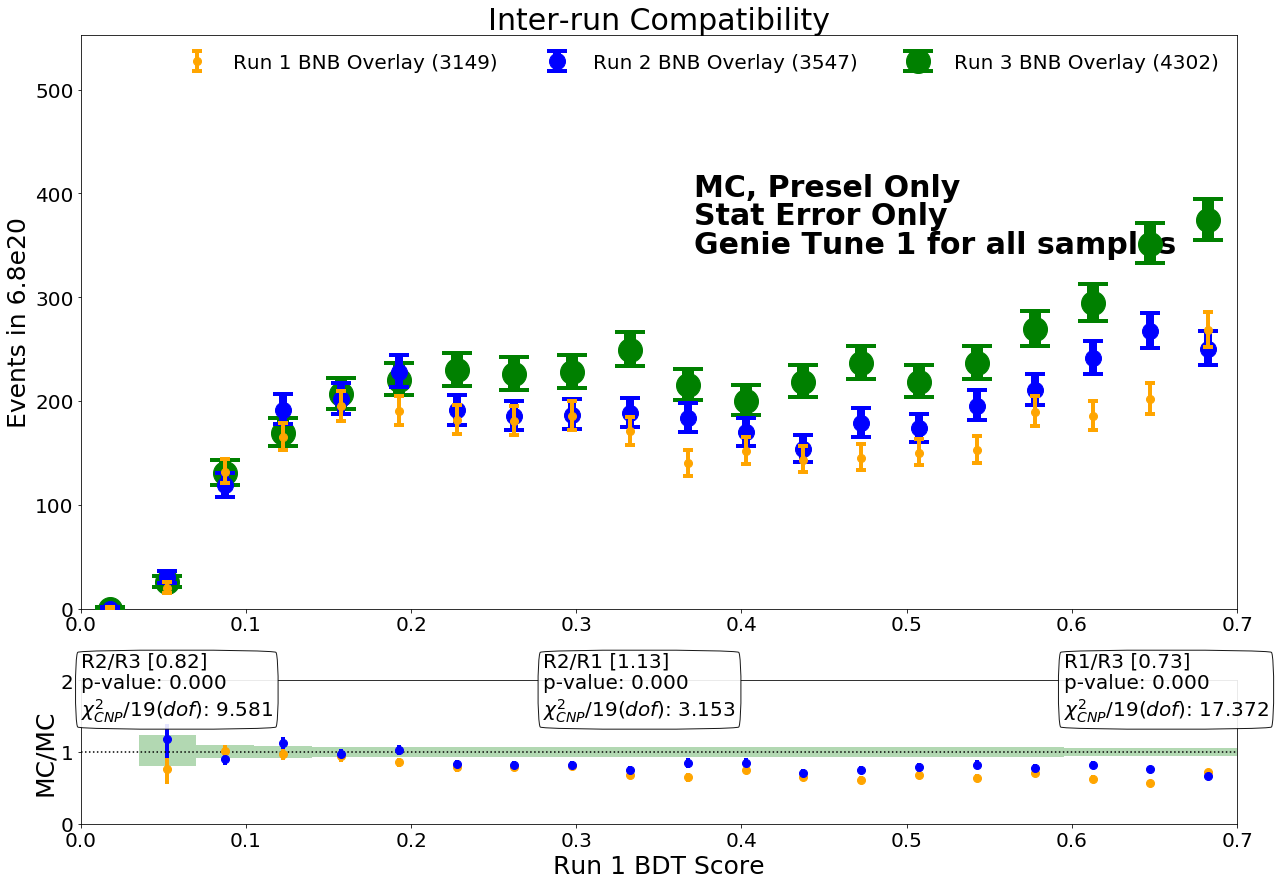

In [20]:
dumpbins=36

fig,ax0,ax1 = datadataplot_wratio('bkgBDT_run1',20,(0,.7),run1NumuHist,run2NumuHist,run3NumuHist,'Run 1 BDT Score',fs=(18,12))

ax0.set_ylabel('Events in 6.8e20',fontsize=25)
ax0.set_title('Inter-run Compatibility',fontsize=30)


ax0.annotate('MC, Presel Only',xy=(.53,.72), xycoords='axes fraction',fontsize=30,color='black',weight = 'bold')
ax0.annotate('Stat Error Only',xy=(.53,.67), xycoords='axes fraction',fontsize=30,color='black',weight = 'bold')
ax0.annotate('Genie Tune 1 for all samples',xy=(.53,.62), xycoords='axes fraction',fontsize=30,color='black',weight = 'bold')


Text(0.53, 0.62, 'Genie Tune 1 for all samples')

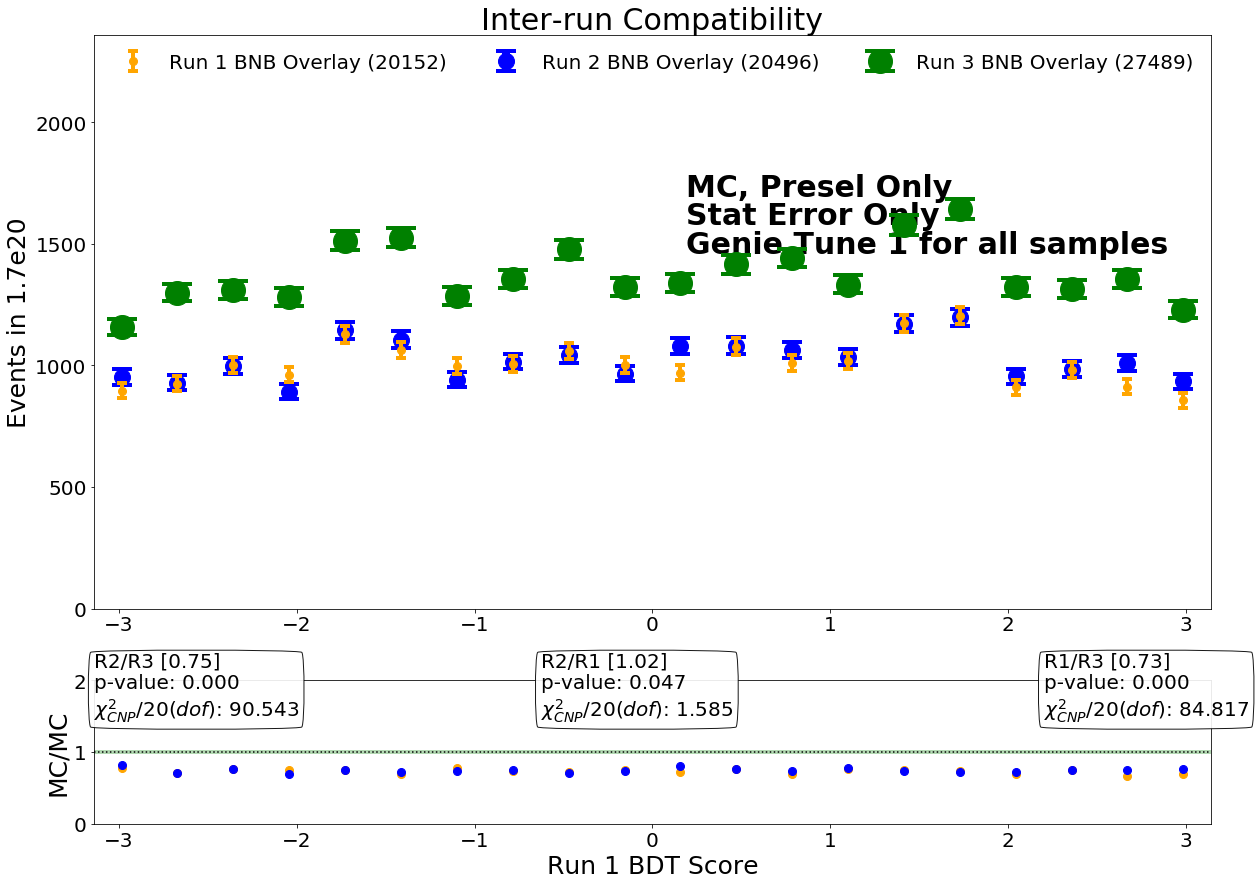

In [21]:
dumpbins=36

fig,ax0,ax1 = datadataplot_wratio('Lepton_PhiReco',20,(-np.pi,np.pi),run1NumuHist,run2NumuHist,run3NumuHist,'Run 1 BDT Score',fs=(18,12))

ax0.set_ylabel('Events in 1.7e20',fontsize=25)
ax0.set_title('Inter-run Compatibility',fontsize=30)


ax0.annotate('MC, Presel Only',xy=(.53,.72), xycoords='axes fraction',fontsize=30,color='black',weight = 'bold')
ax0.annotate('Stat Error Only',xy=(.53,.67), xycoords='axes fraction',fontsize=30,color='black',weight = 'bold')
ax0.annotate('Genie Tune 1 for all samples',xy=(.53,.62), xycoords='axes fraction',fontsize=30,color='black',weight = 'bold')


In [22]:
bdtcuts = 'bkgBDT_univ < .4'
emptycut = 'Enu_1m1p > 0'
morecuts = 'Proton_CosTheta > 0'
bonuscuts = '(MPID_proton > .9 or Enu_1m1p > 400)'

s_cuts = morecuts + ' and ' + bonuscuts + ' and ' + bdtcuts

run1FilterTest.AddCut(s_cuts)
run2FilterTest.AddCut(s_cuts)
run3FilterTest.AddCut(s_cuts)


run1NumuHist.AddCut(s_cuts)
run2NumuHist.AddCut(s_cuts)
run3NumuHist.AddCut(s_cuts)

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide


Text(0.53, 0.67, 'Genie Tune 1 for all samples')

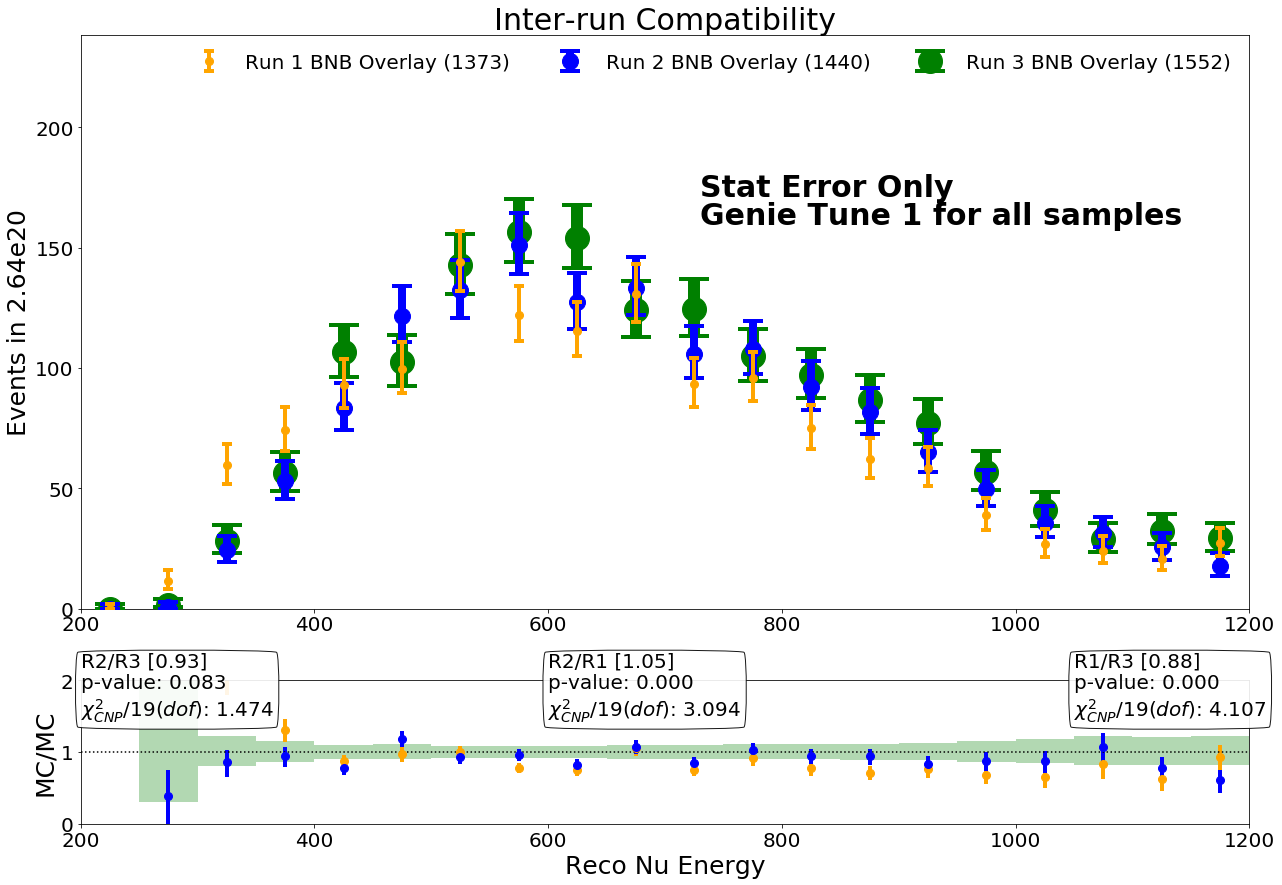

In [23]:
dumpbins=36

fig,ax0,ax1 = datadataplot_wratio('Enu_1m1p',20,(200,1200),run1NumuHist,run2NumuHist,run3NumuHist,'Reco Nu Energy',fs=(18,12))

ax0.set_ylabel('Events in 2.64e20',fontsize=25)
ax0.set_title('Inter-run Compatibility',fontsize=30)

ax0.annotate('Stat Error Only',xy=(.53,.72), xycoords='axes fraction',fontsize=30,color='black',weight = 'bold')
ax0.annotate('Genie Tune 1 for all samples',xy=(.53,.67), xycoords='axes fraction',fontsize=30,color='black',weight = 'bold')


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide


Text(0.53, 0.72, 'Stat Error Only')

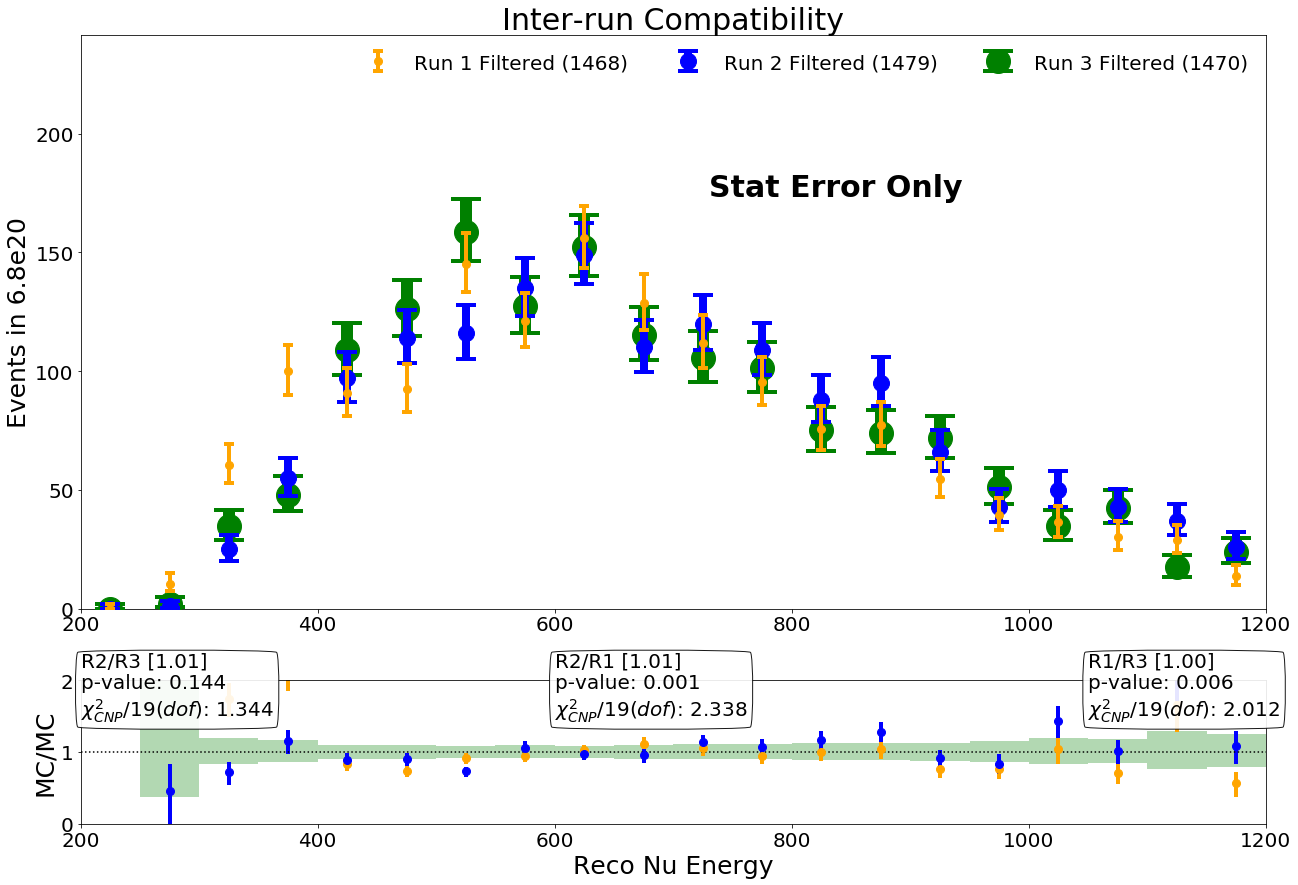

In [24]:
dumpbins=36

fig,ax0,ax1 = datadataplot_wratio('Enu_1m1p',20,(200,1200),run1FilterTest,run2FilterTest,run3FilterTest,'Reco Nu Energy',fs=(18,12))

ax0.set_ylabel('Events in 6.8e20',fontsize=25)
ax0.set_title('Inter-run Compatibility',fontsize=30)

ax0.annotate('Stat Error Only',xy=(.53,.72), xycoords='axes fraction',fontsize=30,color='black',weight = 'bold')
#ax0.annotate('Genie Tune 1 for all samples',xy=(.53,.67), xycoords='axes fraction',fontsize=30,color='black',weight = 'bold')


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide


Text(0.53, 0.72, 'Stat Error Only')

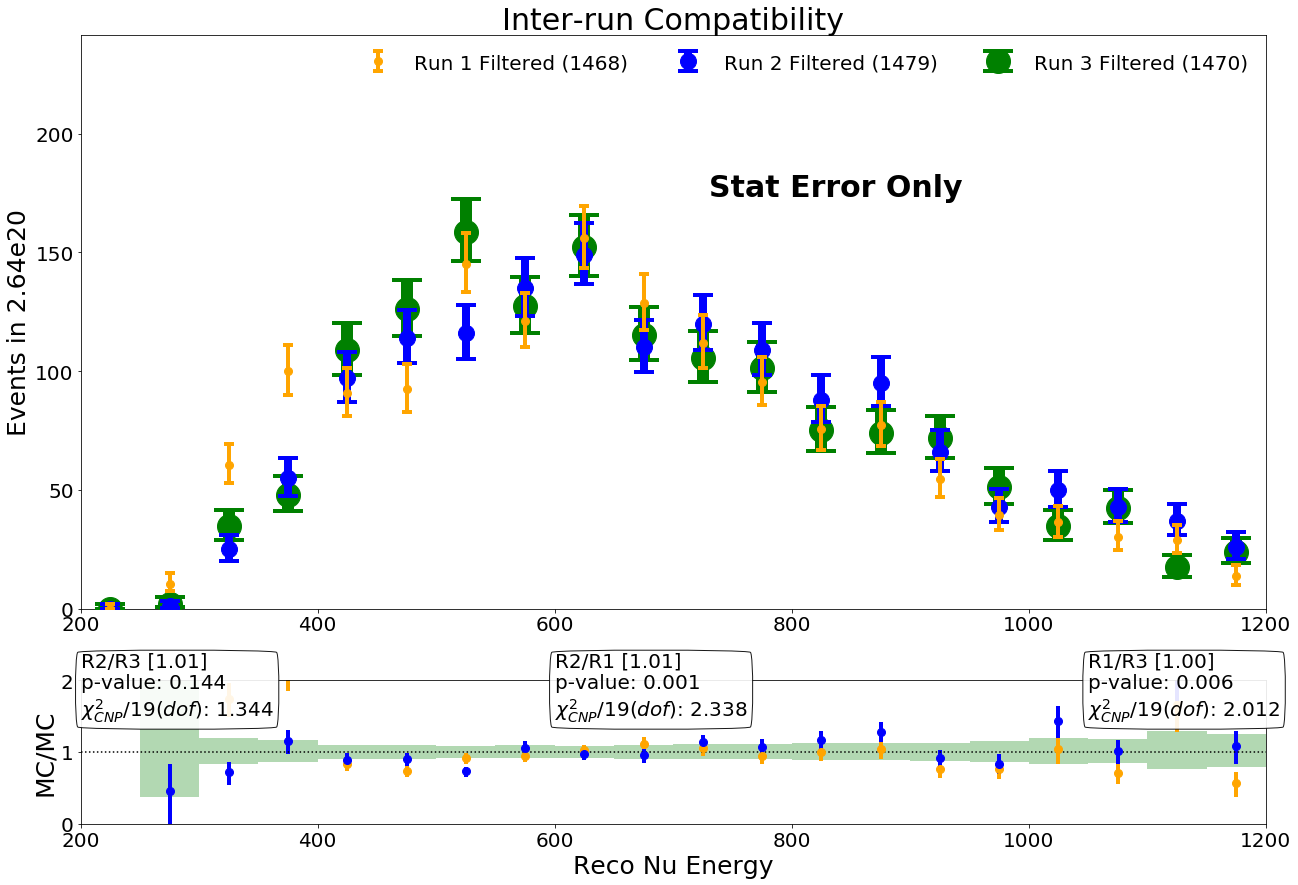

In [26]:
dumpbins=36

fig,ax0,ax1 = datadataplot_wratio('Enu_1m1p',20,(200,1200),run1FilterTest,run2FilterTest,run3FilterTest,'Reco Nu Energy',fs=(18,12))

ax0.set_ylabel('Events in 2.64e20',fontsize=25)
ax0.set_title('Inter-run Compatibility',fontsize=30)

ax0.annotate('Stat Error Only',xy=(.53,.72), xycoords='axes fraction',fontsize=30,color='black',weight = 'bold')
#ax0.annotate('Genie Tune 1 for all samples',xy=(.53,.67), xycoords='axes fraction',fontsize=30,color='black',weight = 'bold')


In [34]:
dumpbins=36

#fig,ax0,ax1,_ = datadataplot_wratio('Enu_1m1p',20,(200,1200),run1FilterTest,run2FilterTest,'Enu_1m1p',fs=(18,12))
fig,ax0,ax1,_ = datadataplot_wratio('Enu_1m1p',20,(200,1200),run2NumuHist,run3NumuHist,'Enu_1m1p',fs=(18,12))


ax0.set_ylabel('Events in 1.7e20')

TypeError: datadataplot_wratio() missing 1 required positional argument: 'stxcoord'

In [60]:
dumpbins = 14
dumphole = 'datadata_run3overrun2_postsel' # where are we dumping these?

dumphole = '%s/%s'%(dumpfolder,dumphole)
if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for x,dist in varListSel.items():
    fig,ax0,ax1,_ = datadataplot_wratio_dvar(dist,14,run3FilterTest,run2FilterTest,fs=(18,12))
    ax0.set_ylabel('Events in 2.64e19',fontsize=25)
    #plt.savefig(dumphole+'/'+dist.myname+'.png')
    plt.close(fig)

1.1199701490141702 0.3333308957387987
0.9306719855052231 0.5242093302539965
0.5975556650448254 0.8694128826976716
0.6703764462530365 0.8056069099361167
0.7796118152056563 0.6723171097201186


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


0.7104838597862019 0.766064439872797
1.1363482974562895 0.3189707601449532
1.5499864975525584 0.09153686789551718
1.0958686256832073 0.35517223761098815
0.7564687699470661 0.7178586321208309
0.6684262624466377 0.8074584239046836
1.016958049999728 0.4321775878268841
0.6121284543249838 0.833959787626002
0.9672621753225763 0.4811961209896318
0.8526444195602912 0.6113605149587715
1.2034260033542419 0.26437048951146735
0.7990094678722262 0.6713558046131924
0.5749632652839675 0.8867320098245077
0.5613759013499903 0.896528414664154
1.1635097319339776 0.2960378209209549
1.2005401079400309 0.2665780985706675
1.303250730040433 0.19582672306452598
0.7680062265310493 0.7053924374867244
0.576505580366092 0.8496302479070243
0.70261828279702 0.7740255960162536
0.9985237806773309 0.451251915010199
0.46208045815233184 0.953247991724135
1.144641388888585 0.31185118797340383
1.2607186839690503 0.2231864333937169
1.672676548275652 0.05380679592988513
1.2162169093226625 0.25473993047414023
0.95810835587359